In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_vae_model import *
from dgr_utils import *
from dgr_linear_classifier import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [ ]:
"""
Features are reconstructed with the VAE model
A LinearClassifier is trained using the reconstructed features
Best F1 score: 0.838
Small reconstruction loss

Pseudo code:
extracted_features <- FeatureExtractor(sentence)
latent_representation <- VAE.encode(extracted_features)
reconstructed_features <- VAE.decode(latent_representation)
linear_model <- train_linear_model(reconstructed_features, labels)
"""

In [4]:
bert_lstm = torch.load('data/model_bert_854.pth')

feature_extractor = torch.load('data/feature_extractor.pth')
feature_classifier = torch.load('data/feature_classifier.pth')

vae = torch.load('data/vae.pth')

In [5]:
train_features_sample = torch.load('data/train_features_sample.pt')
train_features_label = torch.load('data/train_features_label.pt')

val_features_sample = torch.load('data/val_features_sample.pt')
val_features_label = torch.load('data/val_features_label.pt')

In [6]:
train_replay_data, _, _ = vae(train_features_sample)
val_replay_data, _, _ = vae(val_features_sample)

train_replay_data.detach()
val_replay_data.detach()

train_replay_label = train_features_label.long()
val_replay_label = val_features_label.long()

In [7]:
counts = torch.bincount(train_replay_label)
print(counts)

tensor([4840, 2293, 1107], device='cuda:0')


In [8]:
batch_size = 32

train_dataset = TensorDataset(train_replay_data, train_replay_label)
train_dataset_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_dataset_sampler,
                              batch_size=batch_size)

val_dataset = TensorDataset(val_replay_data, val_replay_label)
val_dataset_sampler = RandomSampler(val_dataset)
val_dataloader = DataLoader(val_dataset,
                            sampler=val_dataset_sampler,
                            batch_size=batch_size)

In [9]:
for x, y in train_dataloader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 1024])
torch.Size([32])


In [10]:
replay_model = LinearClassifier()
replay_model.to(device)
print(replay_model)

ReplayClassifier(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [11]:
class_weights = torch.tensor([1 / counts[0].item(),
                              1 / counts[1].item(),
                              1 / counts[2].item()]).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(replay_model.parameters(), lr=0.0005)

In [12]:
evaluate_linear(replay_model, val_dataloader, device)

100%|██████████| 59/59 [00:00<00:00, 578.44it/s]


0.33175653754076356

In [13]:
num_epochs = 25

results = train_linear(replay_model, train_dataloader, val_dataloader,
                optimizer, criterion, num_epochs, device,
                verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:00<00:00, 1093.18it/s]


saving model checkpoint to data/replay_model.pth
[Epoch 1] loss:	194.872, f1 train: 0.806, f1 test: 0.839 


100%|██████████| 59/59 [00:00<00:00, 1092.65it/s]


[Epoch 2] loss:	191.154, f1 train: 0.806, f1 test: 0.836 


100%|██████████| 59/59 [00:00<00:00, 1072.74it/s]


saving model checkpoint to data/replay_model.pth
[Epoch 3] loss:	187.946, f1 train: 0.805, f1 test: 0.840 


100%|██████████| 59/59 [00:00<00:00, 1054.01it/s]


[Epoch 4] loss:	188.379, f1 train: 0.805, f1 test: 0.837 


100%|██████████| 59/59 [00:00<00:00, 1073.68it/s]


[Epoch 5] loss:	189.158, f1 train: 0.801, f1 test: 0.840 


100%|██████████| 59/59 [00:00<00:00, 1113.51it/s]


[Epoch 6] loss:	188.900, f1 train: 0.799, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 819.67it/s]


[Epoch 7] loss:	190.597, f1 train: 0.804, f1 test: 0.839 


100%|██████████| 59/59 [00:00<00:00, 867.40it/s]


[Epoch 8] loss:	190.659, f1 train: 0.802, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 737.35it/s]


[Epoch 9] loss:	189.766, f1 train: 0.803, f1 test: 0.839 


100%|██████████| 59/59 [00:00<00:00, 867.39it/s]


[Epoch 10] loss:	190.781, f1 train: 0.803, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 819.81it/s]


[Epoch 11] loss:	191.512, f1 train: 0.802, f1 test: 0.837 


100%|██████████| 59/59 [00:00<00:00, 854.88it/s]


[Epoch 12] loss:	188.937, f1 train: 0.796, f1 test: 0.835 


100%|██████████| 59/59 [00:00<00:00, 855.10it/s]


[Epoch 13] loss:	189.935, f1 train: 0.804, f1 test: 0.840 


100%|██████████| 59/59 [00:00<00:00, 843.19it/s]


[Epoch 14] loss:	188.695, f1 train: 0.804, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 797.33it/s]


[Epoch 15] loss:	188.671, f1 train: 0.799, f1 test: 0.834 


100%|██████████| 59/59 [00:00<00:00, 776.31it/s]


[Epoch 16] loss:	187.871, f1 train: 0.804, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 1035.62it/s]


[Epoch 17] loss:	187.584, f1 train: 0.802, f1 test: 0.837 


100%|██████████| 59/59 [00:00<00:00, 1112.52it/s]


[Epoch 18] loss:	192.846, f1 train: 0.798, f1 test: 0.836 


100%|██████████| 59/59 [00:00<00:00, 1053.61it/s]


[Epoch 19] loss:	188.782, f1 train: 0.802, f1 test: 0.839 


100%|██████████| 59/59 [00:00<00:00, 1000.45it/s]


[Epoch 20] loss:	189.304, f1 train: 0.800, f1 test: 0.837 


100%|██████████| 59/59 [00:00<00:00, 1016.91it/s]


[Epoch 21] loss:	190.092, f1 train: 0.803, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 966.89it/s]


[Epoch 22] loss:	188.029, f1 train: 0.803, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 999.92it/s]


[Epoch 23] loss:	187.989, f1 train: 0.803, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 1034.67it/s]


[Epoch 24] loss:	191.494, f1 train: 0.803, f1 test: 0.838 


100%|██████████| 59/59 [00:00<00:00, 1073.29it/s]

[Epoch 25] loss:	186.232, f1 train: 0.803, f1 test: 0.838 


In [14]:
y_true_train, y_pred_train = [], []
for x, y in train_dataloader:
    x, y = x.to(device), y.to(device)
    
    log_probs = replay_model(x)
    
    y_batch_pred = torch.argmax(log_probs, dim=1)
    
    y_true_train += list(y.cpu().numpy())
    y_pred_train += list(y_batch_pred.cpu().numpy())

Evaluation on Training dataset
F1 score: 0.803


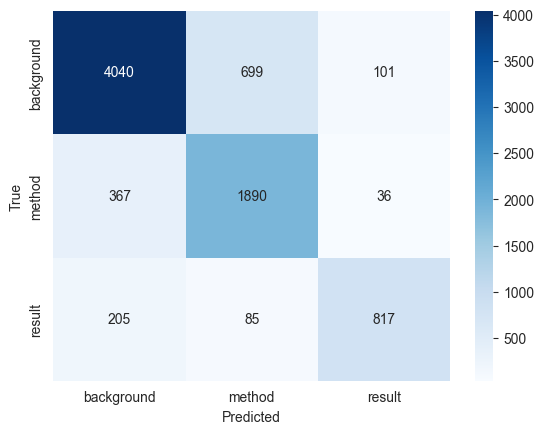

              precision    recall  f1-score   support

  background       0.88      0.83      0.85      4840
      method       0.71      0.82      0.76      2293
      result       0.86      0.74      0.79      1107

    accuracy                           0.82      8240
   macro avg       0.81      0.80      0.80      8240
weighted avg       0.83      0.82      0.82      8240


In [15]:
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true_train, y_pred_train, average='macro')
cm_eval = confusion_matrix(y_true_train, y_pred_train)
report = classification_report(y_true_train, y_pred_train, target_names=label_list)

print("Evaluation on Training dataset")
print('F1 score: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)

In [16]:
y_true_val, y_pred_val = [], []
for x, y in val_dataloader:
    x, y = x.to(device), y.to(device)
    
    log_probs = replay_model(x)
    
    y_batch_pred = torch.argmax(log_probs, dim=1)
    
    y_true_val += list(y.cpu().numpy())
    y_pred_val += list(y_batch_pred.cpu().numpy())

Evaluation on Validation dataset
F1 score: 0.838


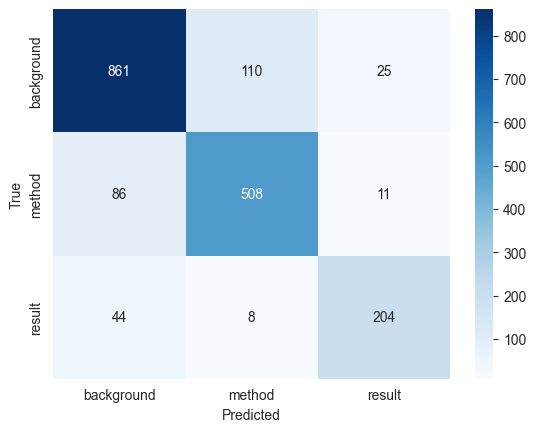

              precision    recall  f1-score   support

  background       0.87      0.86      0.87       996
      method       0.81      0.84      0.83       605
      result       0.85      0.80      0.82       256

    accuracy                           0.85      1857
   macro avg       0.84      0.83      0.84      1857
weighted avg       0.85      0.85      0.85      1857


In [17]:
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true_val, y_pred_val, average='macro')
cm_eval = confusion_matrix(y_true_val, y_pred_val)
report = classification_report(y_true_val, y_pred_val, target_names=label_list)

print("Evaluation on Validation dataset")
print('F1 score: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)